In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import pandas as pd
import random, math, re, time, os, shutil

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam
from keras.losses import CategoricalCrossentropy

In [3]:
BATCH_SIZE = 128
IMG_SIZE = 224
SEED = 33
NUM_COLUMNAS = 200
NUM_TROZOS = 6

directorio = 'NEW-DATASET'

training_directory = f'{directorio}/Training'
validation_directory = f'{directorio}/Validation'
testing_directory = f'{directorio}/Testing'

In [4]:
def crearDatasets(training_directory:str, validation_directory: str, testing_directory: str):
    train_dataset = tf.keras.utils.image_dataset_from_directory(
                training_directory,
                labels='inferred',
                label_mode='categorical',
                image_size=(IMG_SIZE, IMG_SIZE),
                batch_size=BATCH_SIZE,
                seed=SEED
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
                validation_directory,
                labels='inferred',
                label_mode='categorical',
                image_size=(IMG_SIZE, IMG_SIZE),
                batch_size=BATCH_SIZE,
                seed=SEED
    )

    testing_dataset = tf.keras.utils.image_dataset_from_directory(
            testing_directory,
            labels='inferred',
            label_mode='categorical',
            image_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            seed=SEED
    )

    class_names = train_dataset.class_names
    num_classes = len(class_names)

    return train_dataset, validation_dataset, testing_dataset, num_classes

In [5]:
train_dataset, validation_dataset, testing_dataset, num_classes = crearDatasets(training_directory=training_directory, validation_directory=validation_directory, testing_directory=testing_directory )

Found 46211 files belonging to 13 classes.
Found 13194 files belonging to 13 classes.
Found 6595 files belonging to 13 classes.


# MODELO 

In [7]:
from keras.applications import EfficientNetB2

model = Sequential()
model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

efficientNetB2 = EfficientNetB2(weights='imagenet', include_top=False)
efficientNetB2.trainable=False
model.add(efficientNetB2)

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 flatten_1 (Flatten)         (None, 68992)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                4415552   
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 13)                845       
                                                                 
Total params: 12,189,126
Trainable params: 4,420,557
Non-trainable params: 7,768,569
_________________________________________________________________


# Entrenamiento

In [14]:
model.compile(
  optimizer=SGD(learning_rate=0.001),
  loss=CategoricalCrossentropy(),
  metrics=['accuracy']
)

inicio = time.time()

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=1,
                    verbose=1,
                    shuffle=False,
)

fin = time.time()
tiempo = fin - inicio
minutos = int(tiempo/60)
print(f'Tiempo entrenamiento: {minutos} min {round(tiempo-60*minutos,2)} s')

362/362 [==============================] - 89s 235ms/step - loss: 0.1625 - accuracy: 0.9556 - val_loss: 0.1876 - val_accuracy: 0.9451
Tiempo entrenamiento: 1 min 29.38 s


# Resultados

In [ ]:
fig = plt.figure(figsize=(15,5))

# Primera posición en figura de 1 fila y 2 columnas
fig.add_subplot(1,2,1)
plt.title(label='Pérdidas')
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
plt.legend(loc="upper left")

# Segunda posición en figura de 1 fila y 2 columnas
fig.add_subplot(1,2,2)
plt.title(label='Precisiones')
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
plt.legend(loc="upper left")

fig.suptitle('Gráficos EfficientNetB2', fontsize=20)
plt.show()
#---------------------------------
test_loss, test_acc = model.evaluate(testing_dataset, verbose=1)
print('***** Test loss: ', test_loss)
print('***** Test accuracy: ', test_acc)

# Guardar modelo

In [16]:
model_name = "NEW_CYBERRY_model.keras"
model.save(model_name)

# Predecir imágenes

In [17]:
import keras

model_name = "NEW_CYBERRY_model.keras"
model = keras.models.load_model(model_name)

# Matriz de confusión

In [18]:
predicted_labels = []
true_labels = []

datasetIterator = list(testing_dataset.as_numpy_iterator()) 

for imagenes, labels in datasetIterator: 
    true_labels += list(np.argmax(labels, axis=1)) 

    lote = imagenes/255
    predicciones = model.predict(imagenes)
    predicted_labels += list(np.argmax(predicciones, axis=1))   

3/3 [==============================] - 1s 43ms/step


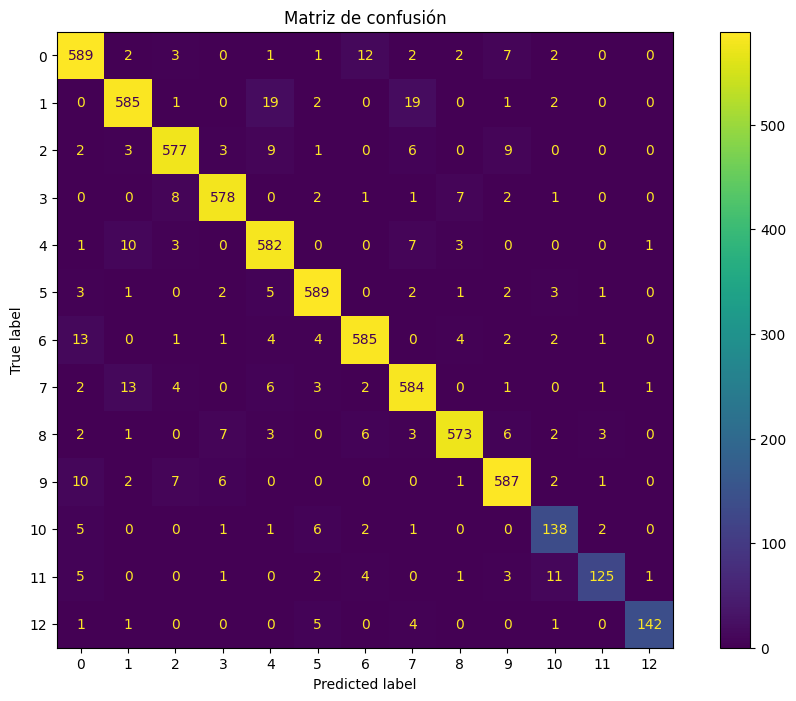

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

matrix = confusion_matrix(true_labels, predicted_labels)

figura, axes = plt.subplots(figsize=(12, 8))
confusionMatrix = ConfusionMatrixDisplay(matrix)  # display_labels=lista_razas_test
confusionMatrix.plot(ax=axes, cmap='viridis')
confusionMatrix.ax_.set_title("Matriz de confusión")

plt.show()

---

In [37]:
classes = os.listdir('NEW-DATASET/Training') 

In [24]:
def trocear_el_sushiV3(imagen: np.ndarray, num_trozos: int):
    lista_de_trocitos = []
    offset = int(NUM_COLUMNAS/num_trozos) # 200/6 = 33
    for trozo in range(num_trozos): 
        trozo_imagen = imagen[15:, trozo*offset:(trozo+1)*offset]
        trozo_imagen = Image.fromarray(trozo_imagen)
        trozo_imagen = trozo_imagen.resize(size=(IMG_SIZE,IMG_SIZE))
        trozo_imagen = np.array(trozo_imagen)
        lista_de_trocitos.append(trozo_imagen)
    return lista_de_trocitos

In [39]:
def make_predictions(imagen):
    cachos_prueba = trocear_el_sushiV3(imagen=imagen, num_trozos=NUM_TROZOS)

    lista_aux = []
    figura = plt.figure(figsize=(15,5))
    i=1
    for trozo in cachos_prueba:
        aux = trozo
        trozo = np.expand_dims(trozo, axis=0)
        label = np.argmax(model(trozo))
        lista_aux.append(str(classes[label]))
        figura.add_subplot(1,6,i)
        i+=1
        plt.imshow(aux)
    plt.show()
    return lista_aux

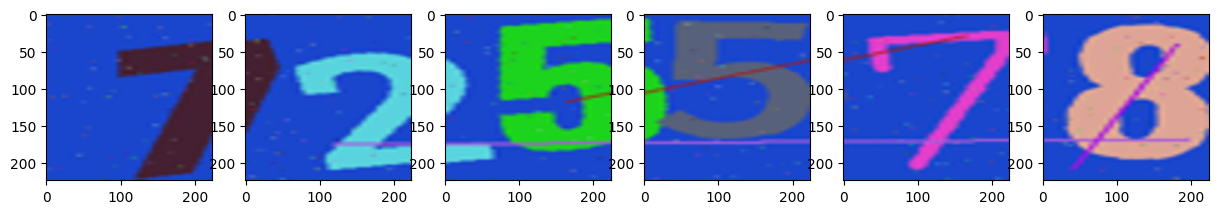

Predicted: 725578


In [78]:
# Una imagen pasada a mano
imagen = Image.open('test/02222.png').resize((200,80))
imagen = np.array(imagen)

lista_aux = make_predictions(imagen)
valor = "".join(lista_aux)
print('Predicted:', valor) # str

In [50]:
def make_predictions_no_plot(imagen):
    cachos_prueba = trocear_el_sushiV3(imagen=imagen, num_trozos=NUM_TROZOS)
    lista_aux = []
    for trozo in cachos_prueba:
        trozo = np.expand_dims(trozo, axis=0)
        label = np.argmax(model(trozo))
        lista_aux.append(str(classes[label]))
    return lista_aux

In [66]:
directory = "test/"

dataframe = pd.DataFrame(columns=('id', 'label'))

for index, filename in enumerate(os.listdir(directory)):
    full_path = f'{directory}/{filename}'
    img = np.array(Image.open(full_path).resize((200,80)))
    lista_aux = make_predictions_no_plot(img)
    valor = "".join(lista_aux)
    dataframe.loc[index] = index, valor
    if index%250 == 0:
        print(index)
dataframe.to_csv('results.csv', index=False) # 23 min

0
250
500
750
1000
1250
1500
1750
2000
2250
